# PyTorch ResNet-50 CIFAR-10 Benchmarks

In [1]:
!lscpu

Architecture:            x86_64
  CPU op-mode(s):        32-bit, 64-bit
  Address sizes:         39 bits physical, 48 bits virtual
  Byte Order:            Little Endian
CPU(s):                  16
  On-line CPU(s) list:   0-15
Vendor ID:               GenuineIntel
  Model name:            11th Gen Intel(R) Core(TM) i7-11700 @ 2.50GHz
    CPU family:          6
    Model:               167
    Thread(s) per core:  2
    Core(s) per socket:  8
    Socket(s):           1
    Stepping:            1
    CPU max MHz:         4900.0000
    CPU min MHz:         800.0000
    BogoMIPS:            4992.00
    Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mc
                         a cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss 
                         ht tm pbe syscall nx pdpe1gb rdtscp lm constant_tsc art
                          arch_perfmon pebs bts rep_good nopl xtopology nonstop_
                         tsc cpuid aperfmperf tsc_known_freq pni pclmulqd

In [2]:
!nvidia-smi

Sat Jun 24 14:12:47 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1660 Ti      Off| 00000000:01:00.0 Off |                  N/A |
|  0%   48C    P8                9W / 130W|     64MiB /  6144MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## device=cuda:0

In [3]:
import torch
import torchvision

In [4]:
LR = 0.001
DOWNLOAD = True
DATA = 'datasets/cifar10/'
device = 'cuda:0'

In [5]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(
        root=DATA,
        train=True,
        transform=transform,
        download=DOWNLOAD
)

train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=64,
        
)

Files already downloaded and verified


In [6]:
model = torchvision.models.resnet50()
model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = LR, momentum=0.9)

In [7]:
%%time

loss_plot = []

model.train()

for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    loss_plot.append(loss.item())
    print('batch_idx: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        batch_idx, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))

/home/dlewis/miniconda3/envs/mlenv/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


batch_idx: 0 [0/50000 (0%)]	Loss: 6.934067
batch_idx: 1 [64/50000 (0%)]	Loss: 6.678445
batch_idx: 2 [128/50000 (0%)]	Loss: 6.378907
batch_idx: 3 [192/50000 (0%)]	Loss: 5.854567
batch_idx: 4 [256/50000 (1%)]	Loss: 5.263757
batch_idx: 5 [320/50000 (1%)]	Loss: 4.932325
batch_idx: 6 [384/50000 (1%)]	Loss: 4.495806
batch_idx: 7 [448/50000 (1%)]	Loss: 3.942691
batch_idx: 8 [512/50000 (1%)]	Loss: 3.477165
batch_idx: 9 [576/50000 (1%)]	Loss: 2.776847
batch_idx: 10 [640/50000 (1%)]	Loss: 2.689921
batch_idx: 11 [704/50000 (1%)]	Loss: 2.617206
batch_idx: 12 [768/50000 (2%)]	Loss: 2.709948
batch_idx: 13 [832/50000 (2%)]	Loss: 2.918701
batch_idx: 14 [896/50000 (2%)]	Loss: 2.441701
batch_idx: 15 [960/50000 (2%)]	Loss: 2.622408
batch_idx: 16 [1024/50000 (2%)]	Loss: 2.704391
batch_idx: 17 [1088/50000 (2%)]	Loss: 2.500768
batch_idx: 18 [1152/50000 (2%)]	Loss: 2.430411
batch_idx: 19 [1216/50000 (2%)]	Loss: 2.617180
batch_idx: 20 [1280/50000 (3%)]	Loss: 2.572624
batch_idx: 21 [1344/50000 (3%)]	Loss: 2.38

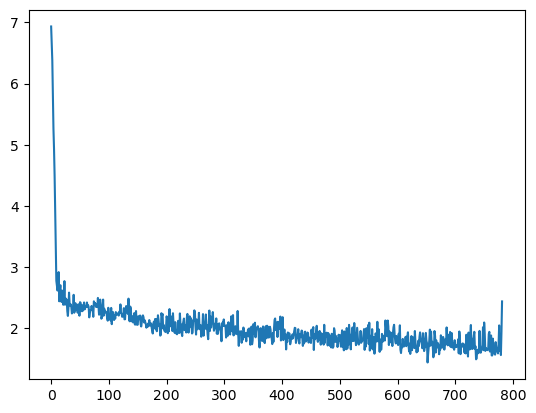

In [8]:
import matplotlib.pyplot as plt

X = range(len(loss_plot))
Y = loss_plot
plt.plot(X, Y)
plt.show()

In [9]:
torch.save({
     'model_state_dict': model.state_dict(),
     'optimizer_state_dict': optimizer.state_dict(),
     }, 'checkpoint.pth')

In [10]:
checkpoint = torch.load('checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [12]:
%%time

model.eval()

test_dataset = torchvision.datasets.CIFAR10(
        root=DATA,
        train=False,
        transform=transform,
        download=DOWNLOAD
)

test_loader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=128,
)

correct = 0
total = 0

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Files already downloaded and verified
Accuracy of the network on the 10000 test images: 32 %
CPU times: user 1min 15s, sys: 2.21 s, total: 1min 17s
Wall time: 32.4 s
